# Assignment 2 - Multi-label classification


### Load Dataset
The VLE provided multi-label yeast dataset was downloaded with the path '/opt/users/gpel0001/cce3503/assignment-2/yeast.csv' and the relative path was used to load the dataset. This dataset contains 14 functional classes of proteins in yeast with 103 descriptive features, containing 2417 samples.

The dataset was loaded using pandas. The shape was read, and we checked the dataset for any missing values or categorical columns. This check was cleared. The head of the dataset was printed to better visualize the dataset we are working with.

In [1]:
import pandas as pd

# Respective path to the downloaded dataset
dataset_path = 'yeast.csv'

# Loading the dataset using pandas
data = pd.read_csv(dataset_path)

# Print the shape of the dataset
print("Shape of the dataset: ", data.shape)

# Check how many missing values are in the dataset
print("Number of missing values in the dataset: ",data.isnull().sum().sum())

# Check for any categorical columns in the dataset
print("Categorical columns in the dataset: ",data.select_dtypes(include=['object']).columns)

# Print the head of the dataset
data.head()

Shape of the dataset:  (2417, 117)
Number of missing values in the dataset:  0
Categorical columns in the dataset:  Index([], dtype='object')


,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,0,0,0,0,0,0,0,0,0,0
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,0,0,0,0,0,0,0,1,1,0
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,0,0,0,0,0,0,0,0,0,0
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,1,1,0,0,0,0,0,0,0,0


### Data Preprocessing
Before we are able to use the dataset to train any type of model, we need to format the data in a processable manner.

First, we split the dataset into its features and multi-label targets. The features are the first 103 columns of the dataset, while the multi-label targets are the last 14 columns.

Then, we apply standardization to the features so that they are more easily interpretable by the model. Here we use the StandardScaler from sklearn.preprocessing as used in the previous assignment. It is important to keep the same standardization technique throughout the entire dataset.

Finally, using the train_test_split function from sklearn.model_selection, we split the dataset into training and testing sets with an 80-20 split. We specified a random state, so that reproduciability can be acheievd when commenting on reuslts, but this feature was removed for some runs to ensure we arent specifying on one case.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into features and multi-label targets. from the observed dataset head
X = data.iloc[:, :103].values  # Features (first 103 columns)
y = data.iloc[:, 103:].values  # Multi-label targets (last 14 columns)

# Initialize the StandardScaler
scaler = StandardScaler()
# Apply the scaler on the features only since the target variables are binary
X = scaler.fit_transform(X) 

# Split the dataset into training and testing sets (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1 Problem transformation 

### Binary Relavance vs Classifier Chains 

**Binary Relevance:**
This is a simplistic approach where we treat each label as a separate single-label classification problem. So if we have 14 labels, we are essentially training 14 different classifiers. This approach does not take into account the dependencies between the labels. Rather, the union of the predictions from the 14 classifiers is the final output [1].

**Classifier Chains:**
In this approach, a number of classifiers are trained. Similar to the Binary Relevance approach, each label is treated as a single-label classification problem. However, the difference is that the input features are linked together in a 'chain'. This chain is formed by concatenating the input features with the predictions of the previous classifiers. This approach takes into account the dependencies between the labels [1].

Comparing the two approaches, Classifier Chains is more complex and computationally expensive. However, it has the potential to perform better than Binary Relevance when dependencies between the labels are present.

The choice depends on the type of dataset and the application. For example if the dataset is to be altered frequently, Binary Relevance might be a better choice, since it is computationally expensive to retrain the classifiers in Classifier Chains. Whilst in Binary Relevance, the classifiers can be trained independently.

In our case it can be forseen that Classifier Chains will perform better since the dataset is a biological dataset with binary labels. The labels outputs are likely to come from feature relationships.

### Binary Relevance Implementation

The implementation instructions were kept very basic. A simple Neural Network Classifier was defined using the MLPClassifier from sklearn. Its parameters initially included a low max_iter of 200 and a basic hidden_layer_sizes of 100. As the model was run, convergence warnings persisted, so the max_iter was increased to 1000. Furthermore, early stopping and n_iter_no_change were added to prevent overfitting and reduce unnecessary prolonged training times. The n_iter_no_change was initially set to 10, but this caused too many abnormal classification reports with zero division errors, so it was increased to 100.

The binary relevance classifier was then defined using the MultiOutputClassifier from sklearn. The classifier was trained on the training data and evaluated on the test data. The classification report was printed out, and the zero_division parameter was set to 0 to prevent zero division errors in the classification report.

The classification report showed relatively good performance with the binary relevance classifier, with 3 labels having zero relevance associated with them. This will then be compared with the other classifier chains and adaptive classifier chains to determine if they are really not relevant or if the binary relevance classifier failed to find potential relationships between the features and the labels.

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Define the Neural Network base classifier with early stopping 
fixed_nn= MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42, early_stopping=True, n_iter_no_change=100)

# Initialize the Binary Relevance multi-label classifier 
binary_relevance_clf = MultiOutputClassifier(fixed_nn)
# Fit the classifier to the training data
binary_relevance_clf.fit(X_train, y_train)

# Predict the target labels
y_pred_br = binary_relevance_clf.predict(X_test)
# Evaluate the classifier with the classification report
print("Binary Relevance Classification Report: ")
# Use of zero_division parameter to avoid division by zero warnings
print(classification_report(y_test, y_pred_br, zero_division=0))

Binary Relevance Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       167
           1       0.60      0.59      0.60       211
           2       0.70      0.66      0.68       196
           3       0.62      0.53      0.57       171
           4       0.62      0.50      0.55       144
           5       0.47      0.36      0.41       127
           6       0.37      0.25      0.30        76
           7       0.33      0.06      0.10        83
           8       0.00      0.00      0.00        30
           9       0.40      0.04      0.07        55
          10       0.00      0.00      0.00        62
          11       0.76      0.95      0.84       366
          12       0.76      0.95      0.85       365
          13       0.00      0.00      0.00         7

   micro avg       0.68      0.62      0.65      2060
   macro avg       0.45      0.39      0.40      2060
weighted avg       0.61      0.62      

### Chains Classifier Implementation

Using the same parameters, the Chains Classifier model was initialized, trained, and evaluated.

From the classification report alone, slight improvements can be observed in the Chains Classifier model compared to the Binary Relevance model, mostly in the macro average and weighted average metrics. This is expected due to the nature of the Chains Classifier model. It was also interesting to note that only the last label (label 13) gave a zero division warning, compared to labels 8, 10, and 13 in the Binary Relevance model. This indicates that the Chains Classifier model was able to find relevance in these labels that the Binary Relevance model could not. Due to its method of chaining the labels together, it was able to relate the labels to each other and find relevance in them.



In [4]:
from sklearn.multioutput import ClassifierChain

# Classifier Chains
chain_clf = ClassifierChain(fixed_nn)

# Train the model using Classifier Chains
chain_clf.fit(X_train, y_train)

# Predict using the Classifier Chains model
y_pred_cc = chain_clf.predict(X_test)

# Evaluate performance
print("Classifier Chains Classification Report:")
print(classification_report(y_test, y_pred_cc, zero_division=0))

Classifier Chains Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.59       167
           1       0.60      0.52      0.56       211
           2       0.71      0.65      0.68       196
           3       0.65      0.60      0.63       171
           4       0.63      0.51      0.56       144
           5       0.52      0.35      0.42       127
           6       0.38      0.32      0.34        76
           7       0.35      0.29      0.32        83
           8       0.50      0.07      0.12        30
           9       0.35      0.13      0.19        55
          10       0.30      0.11      0.16        62
          11       0.77      0.92      0.84       366
          12       0.77      0.92      0.84       365
          13       0.00      0.00      0.00         7

   micro avg       0.67      0.62      0.65      2060
   macro avg       0.51      0.42      0.45      2060
weighted avg       0.64      0.62      

## 2 Adapted algorithm

The Neural Network base classifier was redefined, ensuring that the hyperparameters to be tested are not predefined or fixed as this will defeat the purpose of hyperparameter optimization (HPO). The base neural network was defined without predefining the activation function.

Using the MultiOutputClassifier from sklearn, we can train a single model to predict multiple labels, ensuring each label is treated independently for cross-entropy loss calculations. Wrapper methods can be used to train a single model to predict multiple labels.

A grid of hyperparameters was defined for hyperparameter optimization (HPO).
- The number of neurons in the hidden layer was varied as it can affect the model's capacity to learn and may differ for each label. 
- Different activation functions were considered to ensure a balanced model.
- The learning rate was varied as different labels may converge at different rates.

GridSearchCV from the sklearn library was used for the systematic evaluation of the hyperparameters defined. A KFold cross-validation with 5 splits was used to ensure the model is evaluated on different subsets of the data, ensuring the model generalizes well by training on 4 folds and evaluating on the 5th fold. The n_jobs=-1 parameter was used to utilize all available cores for parallel processing, speeding up the grid search.

The defined model with the grid of hyperparameters was fitted to the training data. The best parameters from the grid search were printed, and the best model was extracted from the grid search.

Finally, predictions were made using the best model, and the classification report was printed to evaluate the model's performance and compore to the previous implementations.


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report

# Define the base neural network without predefining activation
base_nn = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True, n_iter_no_change=100)

# Wrap the neural network in MultiOutputClassifier for multi-label classification
model = MultiOutputClassifier(base_nn)

# Define a grid of hyperparameters for HPO
param_grid = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (150,)],  # Number of neurons in the hidden layer
    'estimator__activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'estimator__learning_rate_init': [1e-3, 1e-4, 1e-5]  # Learning rates
}

# Use GridSearchCV with 5-fold cross-validation for HPO
grid_search = GridSearchCV(model, param_grid, scoring=make_scorer(f1_score, average='macro'), cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
print("Best parameters found:", grid_search.best_params_)
adaptive_model = grid_search.best_estimator_

# Evaluate the best model on the test data
y_pred = adaptive_model.predict(X_test)
print("Best Model - Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


/opt/users/gpel0001/cce3503/cce3503-venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: {'estimator__activation': 'tanh', 'estimator__hidden_layer_sizes': (50,), 'estimator__learning_rate_init': 0.0001}
Best Model - Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.54      0.63       167
           1       0.52      0.46      0.49       211
           2       0.66      0.69      0.67       196
           3       0.64      0.65      0.64       171
           4       0.53      0.43      0.48       144
           5       0.45      0.34      0.39       127
           6       0.37      0.20      0.26        76
           7       0.41      0.14      0.21        83
           8       0.23      0.10      0.14        30
           9       0.31      0.09      0.14        55
          10       0.25      0.05      0.08        62
          11       0.77      0.89      0.83       366
          12       0.77      0.88      0.82       365
          13       0.00      0.00      0.00         7

   micro avg  

## 3 Performance evaluation 

### F1 Score Comparison
The F1 score is a metric that combines both precision and recall into a single value. So it considers both false positives and false negatives. Basically giving an evaluation of the model's accuracy from a macro and micro perspective.

A respective function that makes use of the sklearn's f1_score function to calculate the F1 score for each label and then plots the comparison of the F1 scores across different methods is defined. Printing the overall performance metrics for each method.

The plot lets us see each label's F1 score for each method, and the overall performance metrics show the macro and micro F1 scores for each method.

From the results we can see how the Binary Relevance seems to split the labels with either high f1 scores or else non at all, while the Classifier Chains and Adaptive Model seem to have a more balanced distribution of F1 scores distributed across the labels.

The Chains Classifier through this review had the best overall performance with the highest macro and micro F1 scores. Followed by the Adaptive Model and then the Binary Relevance method. So we were not able to reach the precision of the Chains method with our adapted single classifier model. However, a significant improvement was made compared to the Binary Relevance method in a macro perspective. It is important to look at the individual label bar plots rather than just the overall performance metrics, since it shows how some lables are threated differently by the various methods.

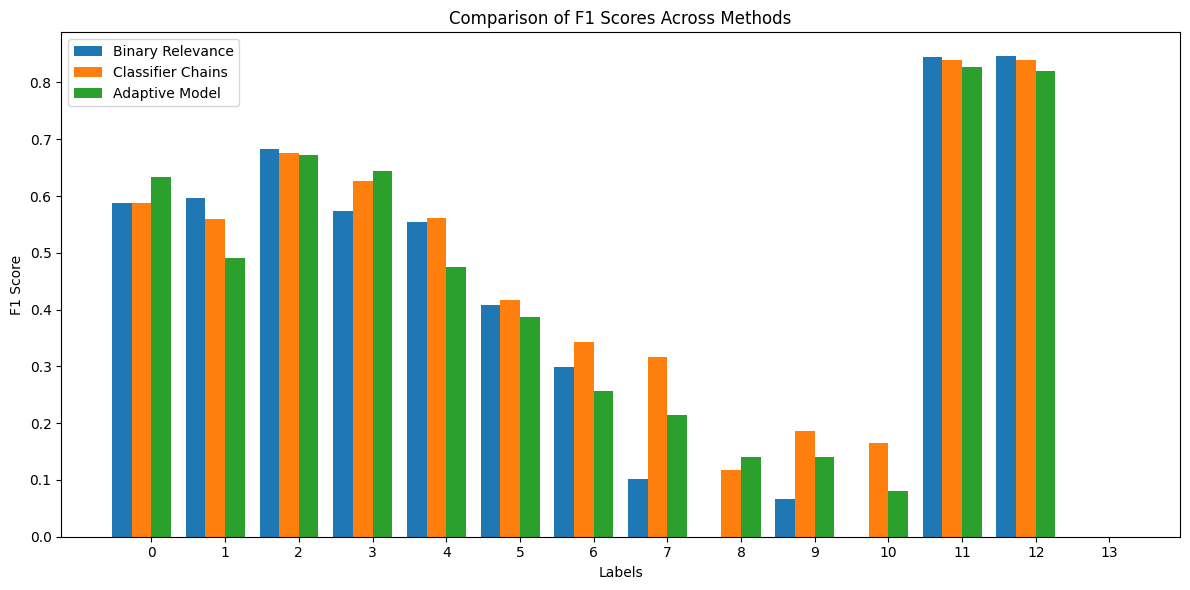

Overall Performance Comparison:
Binary Relevance - Macro F1: 0.3973, Micro F1: 0.6461
Classifier Chains - Macro F1: 0.4453, Micro F1: 0.6465
Adaptive Model - Macro F1: 0.4130, Micro F1: 0.6247


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Function to compare F1-scores across different methods
def f1_scores(y_true, predictions, method_names):

    # Check if the number of predictions and method names match
    if len(predictions) != len(method_names):
        raise ValueError("The number of predictions and method names must match.")

    # Calculate label-wise F1-scores for all methods
    f1_scores = [f1_score(y_true, pred, average=None) for pred in predictions]

    # Create bar plot by adjusting the bar width and positions
    labels = np.arange(len(f1_scores[0]))  
    bar_width = 0.8 / len(predictions)  

    # Begin plotting
    plt.figure(figsize=(12, 6))
    # Iterate through each method and plot the F1-scores
    for i, (f1, name) in enumerate(zip(f1_scores, method_names)):
        plt.bar(
            labels + (i - len(predictions) / 2) * bar_width,
            f1,
            bar_width,
            label=name
        )

    plt.xlabel("Labels")
    plt.ylabel("F1 Score")
    plt.title("Comparison of F1 Scores Across Methods")
    plt.xticks(labels, labels)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and print overall performance metrics for each method
    print("Overall Performance Comparison:")
    for name, pred in zip(method_names, predictions):
        macro_f1 = f1_score(y_true, pred, average='macro')
        micro_f1 = f1_score(y_true, pred, average='micro')
        print(f"{name} - Macro F1: {macro_f1:.4f}, Micro F1: {micro_f1:.4f}")
        
# Define the method names to be displayed in the plot
method_names = ["Binary Relevance", "Classifier Chains", "Adaptive Model"]
# Define the list of predictions to be compared
predictions = [y_pred_br, y_pred_cc, y_pred]

# Utilize the F1-scores function to compare the methods
f1_scores(y_test, predictions, method_names)

### Hamming Loss Comparision

The Hamming Loss metric is also used by defining a function that compares the Hamming Loss across different models. Making use of the sklearn hamming_loss function, giving visual and printed results for the comparison. 

The hamming loss is calculated as the fraction of labels that are incorrectly predicted. The lower the value, the better the model performance. So Binary Relevance showed the lowest Hamming Loss of 0.2053, which corresponds to 20.53% of the labels being incorrectly predicted. 

The differnce in the Hamming Loss values between the models is not very significant and the marginality proves that they all perform similarly. Evaluting the other metric will give a better understanding for comparison.

Hamming Loss Results:
Binary Relevance: 0.2053
Classifier Chains: 0.2071
Adaptive Model: 0.2174


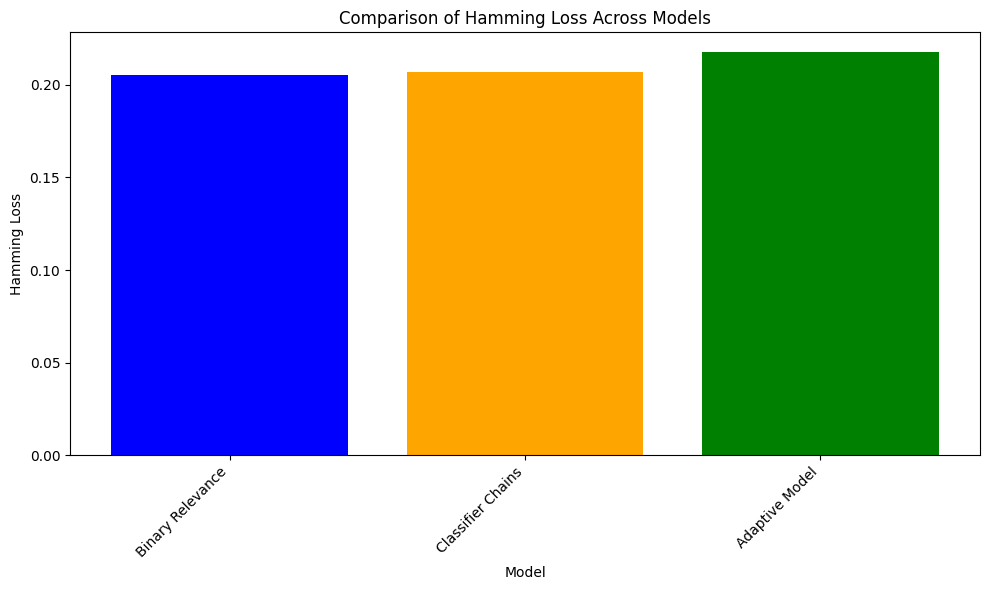


Hamming Loss Comparison:
Binary Relevance - Hamming Loss: 0.2053
Classifier Chains - Hamming Loss: 0.2071
Adaptive Model - Hamming Loss: 0.2174


In [7]:
from sklearn.metrics import hamming_loss

def hamming_loss_comparision(models, method_names, X_test, y_test):
    predictions = []

    # For each model, generate their predictions
    for model in models:
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    hamming_results = {}

    # Calculate Hamming Loss for each model
    for idx, y_pred in enumerate(predictions):
        name = method_names[idx]
        hamming_loss_score = hamming_loss(y_test, y_pred)
        hamming_results[name] = hamming_loss_score

    print("Hamming Loss Results:")
    for model, score in hamming_results.items():
        print(f"{model}: {score:.4f}")

    # Plotting the results
    names = list(hamming_results.keys())
    hamming_scores = list(hamming_results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(names, hamming_scores, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Hamming Loss')
    plt.title('Comparison of Hamming Loss Across Models')
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    # Print the overall performance comparison
    print("\nHamming Loss Comparison:")
    for model, score in hamming_results.items():
        print(f"{model} - Hamming Loss: {score:.4f}")
    return 

# Define the list of models
models = [binary_relevance_clf, chain_clf, adaptive_model]

# Utilize the Hamming Loss function to compare the models
hamming_loss_comparision(models, method_names, X_test, y_test)

### Exact Match Ratio Comparision (EMR)

The Exact Match Ratio is a metric that calculates the proportion of samples where all the labels are correctly predicted. The same method of defining a relevant function to plot and give an overall performance comparison is used.

The results of the EMR were very low, which is expected since the dataset requires predicting all labels correctly when there are 103 features that have also undergone standard scaling.

However, we may still note from the results that the Binary Relevance method actually placed higher than the adaptive model in terms of the Exact Match Ratio. This might have been caused by the limited options the hyperparameter optimization was given. If more than 3 options were provided, the adaptive model might have performed better than the Binary Relevance method. However, the best performing method remains the classifier chains method.

It can also be noted that in our dataset, the Exact Match Ratio is considered the same as the Accuracy score since the dataset has binary labels. Therefore, the accuracy score cannot be partially correct by nature, so it directly translates to the Exact Match Ratio.

Exact Match Ratio Results:
Binary Relevance: 0.1508
Classifier Chains: 0.2087
Adaptive Model: 0.1343


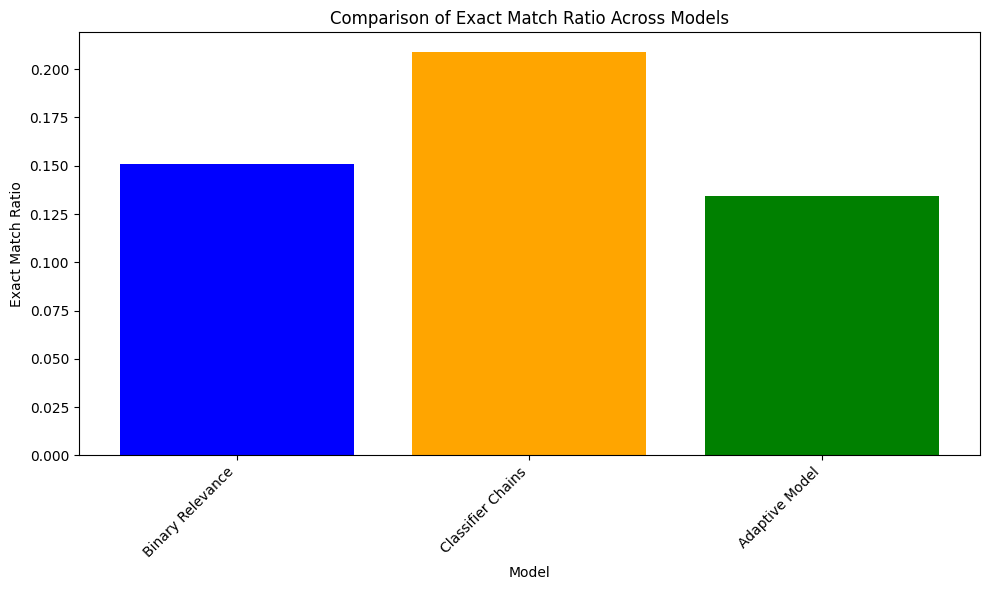


Exact Match Ratio Comparison:
Binary Relevance - Exact Match Ratio: 0.1508
Classifier Chains - Exact Match Ratio: 0.2087
Adaptive Model - Exact Match Ratio: 0.1343


In [8]:
def emr(models, method_names, X_test, y_test):
    predictions = []

    # For each model, generate their predictions
    for model in models:
        y_pred = model.predict(X_test)
        predictions.append(y_pred)

    emr_results = {}

    # Calculate Exact Match Ratio for each model
    for idx, y_pred in enumerate(predictions):
        name = method_names[idx]
        emr_score = np.mean((y_pred == y_test).all(axis=1))
        emr_results[name] = emr_score

    print("Exact Match Ratio Results:")
    for model, score in emr_results.items():
        print(f"{model}: {score:.4f}")
    
    # Plotting the results
    names = list(emr_results.keys())
    emr_scores = list(emr_results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(names, emr_scores, color=['blue', 'orange', 'green', 'red'])
    plt.xlabel('Model')
    plt.ylabel('Exact Match Ratio')
    plt.title('Comparison of Exact Match Ratio Across Models')
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

    # Print the overall performance comparison
    print("\nExact Match Ratio Comparison:")
    for model, score in emr_results.items():
        print(f"{model} - Exact Match Ratio: {score:.4f}")

    return 

# Utilize the Exact Match Ratio function to compare the models
emr(models, method_names, X_test, y_test)

## 4 Conclusion

The implementations of multi-label classification methods were kept simple to facilitate understanding of their parameters and the usage of sklearn methods. The main challenge was achieving a comprehensive comparison due to the closeness in their performances. The classifier chains method emerged as the best multi-label classification method for the yeast dataset. Its ability to capture label dependencies sequentially resulted in fewer labels being zero-classified, with only one label, compared to binary relevance’s three.

The binary relevance method is a computationally efficient and simple method. While it performed well in micro F1 scores, indicating good individual label predictions, it failed to perform as well as the classifier chains method in macro F1 scores, which consider overall performance. It did not capture the relationships between the labels, leading to suboptimal performance. This is particularly evident given the dataset's complexity, which required a more nuanced evaluation of binary classifications.

The adaptive model showed promise in identifying the best hyperparameters for the neural network but could not outperform the other methods. The hyperparameters might have been limited with only three options for each parameter, which could have been improved to achieve better results. The adaptive model lagged behind the original binary relevance method in terms of micro F1 scores but outperformed it in macro F1 scores. This positions it as an intermediate method between the binary relevance and classifier chains methods.

For all methods, a zero-division parameter was used to avoid division by zero warnings. This was necessary because some labels were not predicted at all, which would otherwise result in a division by zero error.

A limiting factor of the comparison was the closeness in the performance of the methods. This made it difficult to identify a clear distinction between the methods. However, through the nature of the classifiers, assumptions could be made about their performance. The error metrics rate (EMR) was very low for all methods, indicating that the models were not often able to predict all labels correctly. The accuracy score would yield the same results as the EMR due to the binary classification of the labels.

A model using the adaptive method but built on the classifier chains method could be a good approach to improve the model's performance. This would allow the model to adapt to the data and label dependencies while still benefiting from the sequential processing of the classifier chains method. This could be an effective strategy for enhancing the model’s performance.

## References

[1]. Spiteri, T. (Year). CCE3503—Practical Machine Learning: Multi-label classification. VLE. University of Malta. [Email: trevor.spiteri@um.edu.mt]
